In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import string

import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB
from gensim.models import Word2Vec

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Data Preprocessing

In [2]:
review = pd.read_csv("/Data/review2.csv")
review.head()

,date,location,review,stars,username
0,4/11/2021,"San Francisco, CA",so I forgot to take pictures except for the fi...,5 star rating,Stephanie N.
1,3/9/2021,"Berkeley, CA",This is the 3rd time I've come to Brophy's and...,5 star rating,Francina O.
2,12/6/2020,"Los Angeles, CA","If you're in Santa Barbara, you have to come h...",5 star rating,Elayna N.
3,5/27/2021,"Solvang, CA",Brophys restaurant & clam bar is a must if you...,5 star rating,Patrick D.
4,5/23/2021,"Gardena, CA",Service 5Ambience 5Location 10!But the food re...,3 star rating,S L.


In [3]:
## change stars string to integer
stars = review["stars"].tolist()
stars_value = [int(re.findall(r'\d+', i)[0]) for i in stars]
review["stars"] = stars_value

In [4]:
df = review
df.head()

,date,location,review,stars,username
0,4/11/2021,"San Francisco, CA",so I forgot to take pictures except for the fi...,5,Stephanie N.
1,3/9/2021,"Berkeley, CA",This is the 3rd time I've come to Brophy's and...,5,Francina O.
2,12/6/2020,"Los Angeles, CA","If you're in Santa Barbara, you have to come h...",5,Elayna N.
3,5/27/2021,"Solvang, CA",Brophys restaurant & clam bar is a must if you...,5,Patrick D.
4,5/23/2021,"Gardena, CA",Service 5Ambience 5Location 10!But the food re...,3,S L.


In [5]:
##remove some character references such as “&amp;amp;”
df['review'] = [i.replace("&amp;amp;", '').replace("\'",'').replace("\xa0", '') for i in df['review']]

In [6]:
#!pip install langdetect

#from langdetect import detect_langs
#language = [detect_langs(i) for i in df.review]
#languages = [str(i[0]).split(':')[0] for i in language]
#df['language'] = languages


#lan = df.language.tolist()

#freq = {} 
#for item in lan: 
#    if (item in freq): 
#        freq[item] += 1
#    else: 
#        freq[item] = 1
        
#freq

### Exploratory Data Analysis

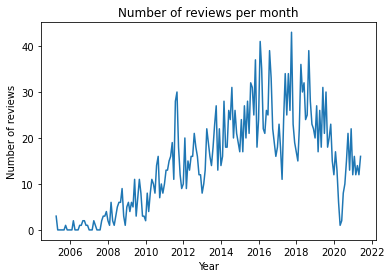

In [7]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
plt.plot(df['review'].resample('M').count())
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.title('Number of reviews per month')
plt.show()

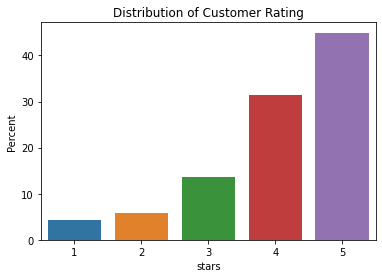

In [8]:
ax = sns.barplot(data=df, x='stars', y='stars', estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")
plt.title('Distribution of Customer Rating')
plt.show()

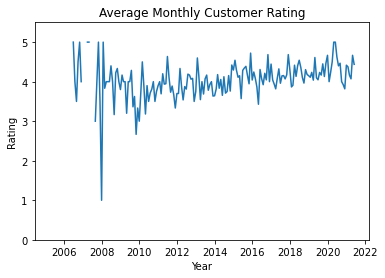

In [9]:
plt.plot(df['stars'].resample('M').mean())
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average Monthly Customer Rating')
plt.ylim(0,5.5)
plt.show()

## Text Mining

### Stopwords

Some worad are not informative such as “a”, “an”, “the”, “and” in English.

Two sets of stopwords from `nltk.corpus` and `sklearn.feature_extraction.stop_words`.

In [10]:
# set stop words
my_stop_words = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))

### WordCloud

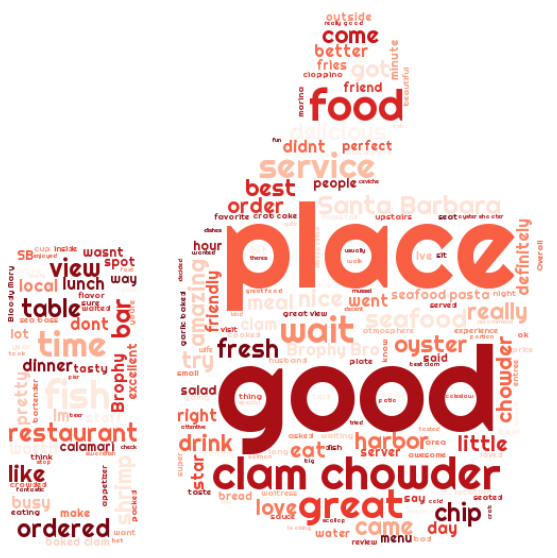

In [11]:
pos_mask = np.array(Image.open('thumbs-up-solid.png'))

# concatenate all the reviews into one single string 
full_text = ' '.join(df['review'])
cloud_no_stopword = WordCloud(background_color='white',mask=pos_mask, stopwords=my_stop_words,colormap="Reds",
                              font_path='/Users/apple/234/Righteous/Righteous-Regular.ttf').generate(full_text)
plt.figure(figsize=(20,10))
plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')
plt.show()

From the above wordcloud plot:

* good: overall, postive reviews. These may be due to its service, time, etc.
* place: location matters?
* indicates sone information of the menu, calm chowder, shrimp, oyster 

### Tokenization and Bag-of-Words (BoW)

#### Unigram Dist

In [12]:
stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer()

In [13]:
def text_process(data):
    '''
    Takes in a df in format of [text] performs the following:
    1. Lower capital letters
    2. Remove all punctuation
    3. Remove all stopwords
    4. Reduce words to their word stem
    5. Return a list of words
    
    '''
    for i in range(len(data)):
        line = data[i]
        line = line.lower() # lower case
        translation = str.maketrans("","", string.punctuation);
        line = line.translate(translation)
        split = word_tokenize(line)
         # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        filtered = []
        for token in split:
            if re.search('[a-zA-Z]', token):    
                filtered.append(token)
        word = [i for i in filtered if i not in my_stop_words]
        
        d = [stemmer.stem(word) for word in word] 
        d = [wordnet_lemmatizer.lemmatize(word) for word in d]
        data[i] = d
    return data

In [14]:
reviews = list(df["review"])
reviews = text_process(reviews)

review_all = list()

for i in range(len(reviews)):
    review_all = review_all + reviews[i]

In [15]:
token_dist = FreqDist(review_all)
dist = pd.DataFrame(token_dist.most_common(20),columns=['Word', 'Frequency'])
dist

,Word,Frequency
0,clam,2338
1,good,1872
2,chowder,1796
3,place,1636
4,great,1609
5,food,1515
6,wait,1446
7,seafood,1367
8,fish,1348
9,view,1084


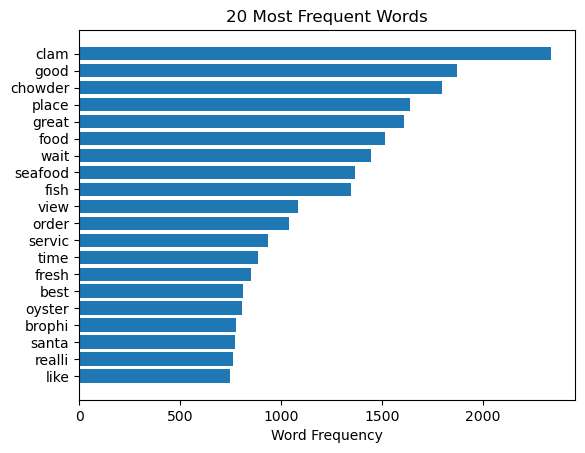

In [16]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(dist["Word"]))
ax.barh(y_pos, dist["Frequency"], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(dist["Word"])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Word Frequency')
ax.set_title('20 Most Frequent Words')
plt.show();

#### Bigram Dist

Under the Bag-of-Words approach, the word order is discarded. However, in many cases, the sequence of words is very important.

In [17]:
vect = CountVectorizer(stop_words=my_stop_words, ngram_range=(2,2))
bigrams = vect.fit_transform(df['review'])
bigram_df = pd.DataFrame(bigrams.toarray(), columns=vect.get_feature_names())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(by='frequency', ascending=False).head(20)

In [18]:
bigram_frequency

,bigram,frequency
13171,clam chowder,1411
55809,santa barbara,720
25044,fish chips,663
8443,brophy bros,328
57305,seafood pasta,277
4279,baked clams,225
56928,sea bass,208
16119,crab cakes,155
28026,garlic baked,146
30259,great food,144


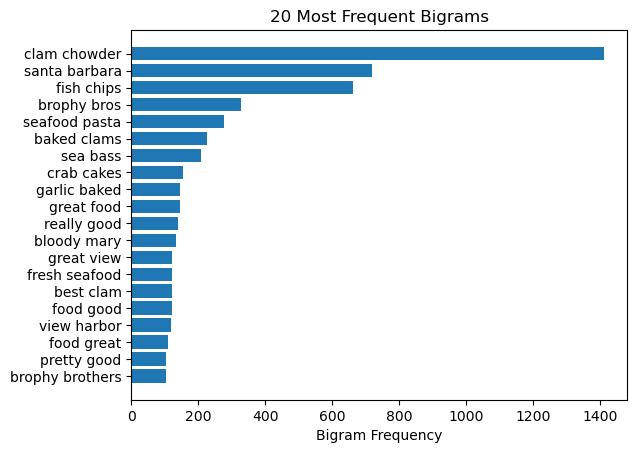

In [19]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(bigram_frequency["bigram"]))
ax.barh(y_pos, bigram_frequency["frequency"], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(bigram_frequency["bigram"])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Bigram Frequency')
ax.set_title('20 Most Frequent Bigrams')
plt.show();

Top 3 menu itmes: clam chowder, fish chips, seafood pasta

## Why people love it? Word2vec

The Word2Vec model returns the surrounding words and distribution. It uses a neural network model to learn word associations from the corpus. Compared to BOW and n-grams, Word2Vec leverages the context and better captures the meaning and relationship of the word.

There are two model architectures behind Word2Vec: continuous Bag-of-Words (CBOW) and skip-gram. In general, CBOW is faster while skip-gram is slower but does a better job in representing infrequent words.

#### Positive Reviews

star >= 4

In [20]:
df_good = df.loc[(df['stars']>=4),:]
df_good.shape

(2146, 4)

In [21]:
df_good.head()

,location,review,stars,username
date,,,,
2021-04-11,"San Francisco, CA",so I forgot to take pictures except for the fi...,5,Stephanie N.
2021-03-09,"Berkeley, CA",This is the 3rd time Ive come to Brophys and I...,5,Francina O.
2020-12-06,"Los Angeles, CA","If youre in Santa Barbara, you have to come he...",5,Elayna N.
2021-05-27,"Solvang, CA",Brophys restaurant & clam bar is a must if you...,5,Patrick D.
2021-05-14,"San Francisco, CA",Visiting SB for my birthday weekend and the re...,5,Rachel S.


In [22]:
good_reviews = ' '.join(df_good.review)
# split the long string into sentences
sentences_good = sent_tokenize(good_reviews)

In [23]:
good_token_clean = list()
# get tokens for each sentence
for sentence in sentences_good:
    eng_word = re.findall(r'[A-Za-z]+', sentence)
    good_token_clean.append([i.lower() for i in eng_word if i.lower() not in my_stop_words])

Set `sg=1`, skip gram. More details: https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec

In [24]:
model_sg = Word2Vec(sentences=good_token_clean, vector_size=500, window=10, min_count=1, workers=4, sg=1)

`predict_output_word`: get the probability distribution of the center word given context words.

In [25]:
model_sg.predict_output_word(['service'], topn=10)

[('staff', 0.0032073392),
 ('friendly', 0.0031391282),
 ('atmosphere', 0.0020922543),
 ('service', 0.0019747324),
 ('attentive', 0.0019556547),
 ('fast', 0.001745585),
 ('super', 0.0013676244),
 ('awesome', 0.0013351446),
 ('prices', 0.0013180494),
 ('views', 0.0012066438)]

Obviously, people really appreciate their friendly customer service as well as the fast and quick response. 

## Sentiment Analysis

### Lexicon-based Tool — VADER

This method has a predefined list of words with sentiment scores and it matches words from the lexicon with words from the text. For each piece of text, the `VADER` analyzer in the `NLTK` package provides four scores: negative, neutral, positive and compound. For the compound score, it is a combination of positive and negative scores and ranges from -1 to 1: below 0 is negative and above 0 is positive.

In [26]:
# Instantiate new SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
# Generate sentiment scores
sentiment_scores = df['review'].apply(sid.polarity_scores)
sentiment = sentiment_scores.apply(lambda x: x['compound'])
monthly_sentiment = sentiment.resample('M').mean()

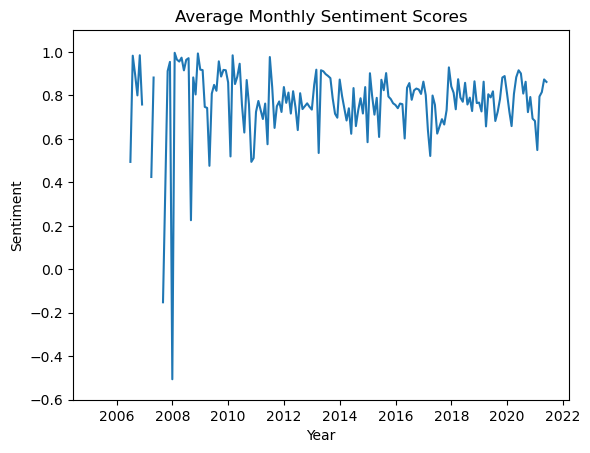

In [27]:
plt.plot(monthly_sentiment)
plt.xlabel('Year')
plt.ylabel('Sentiment')
plt.title('Average Monthly Sentiment Scores')
plt.ylim(-0.6,1.1)
plt.show();

### Simple Supervised Learning Classifiers

#### Label:

1-2:negative, 4-5: postive

In [28]:
df_update = df.loc[~(df["stars"]==3),:]
df_update["label"] = np.where(df_update["stars"]>=4,True,False)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
df_update.head()

,location,review,stars,username,label
date,,,,,
2021-04-11,"San Francisco, CA",so I forgot to take pictures except for the fi...,5,Stephanie N.,True
2021-03-09,"Berkeley, CA",This is the 3rd time Ive come to Brophys and I...,5,Francina O.,True
2020-12-06,"Los Angeles, CA","If youre in Santa Barbara, you have to come he...",5,Elayna N.,True
2021-05-27,"Solvang, CA",Brophys restaurant & clam bar is a must if you...,5,Patrick D.,True
2021-05-14,"San Francisco, CA",Visiting SB for my birthday weekend and the re...,5,Rachel S.,True


#### SVM 

Output bar chart with the most important 10 features contributing to negative and positive review. This is simple analysis. For comparsion of different classifiers, see top 10 data analysis.

Use tf-idf to generate the X matrix instead of BOW, due to the limatation of BOW.

In [30]:
def onegram(train,restaurant):

    train_data =  list(train['review'])    # text
    train_label = list(train["label"])
    
    text = text_process(train_data)
    text = sum(text,[])
    text = set(text)
    text = list(text)
    transformer = TfidfVectorizer() 
    cvectorizer = transformer.fit(text)
    transformed = cvectorizer.transform(train['review'])  
#     print(cvectorizer.get_feature_names())

    # SVM
    clf = LinearSVC()
    clf.fit(transformed,train_label)
    
    coefficients = clf.coef_.ravel()
    pos_coefficients = np.argsort(coefficients )[-10:]
    neg_coefficients = np.argsort(coefficients )[:10]
    combine = np.hstack([neg_coefficients, pos_coefficients])
    
    plt.figure(figsize=(7, 4))
    colors = ['red' if i < 0 else 'blue' for i in coefficients[combine]]
    plt.bar(np.arange(2 * 10), coefficients[combine], color=colors)
    feature_names = np.array(cvectorizer.get_feature_names())
    
    plt.title('Why '+ restaurant +' is rated as bad or good', fontsize = 15)
    plt.xticks(np.arange( 0, 2 * 10), feature_names[combine], rotation=40, ha='right')
    plt.show()

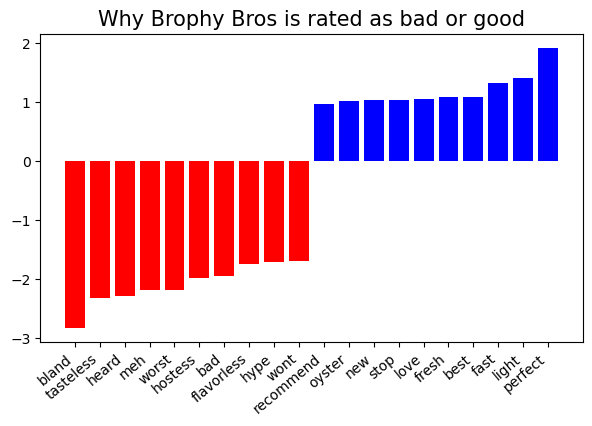

In [31]:
onegram(df_update,"Brophy Bros")

In [32]:
def bigram(train,restaurant):
    # only use true review
    
    train_data =  list(train['review'])    # text
    train_label = list(train["label"])
    
    # TfidfVectorizer Transform
    transformer = TfidfVectorizer(stop_words ='english', ngram_range=(2,2))  # "ignore terms that appear in less than 1% of the documents".
    cvectorizer = transformer.fit(train['review'])
    transformed = cvectorizer.transform(train['review'])

    
    
    # SVM regression
    clf = LinearSVC()
    clf.fit(transformed,train_label)
    
    coefficients = clf.coef_.ravel()
    pos_coefficients = np.argsort(coefficients )[-10:]
    neg_coefficients = np.argsort(coefficients )[:10]
    combine = np.hstack([neg_coefficients, pos_coefficients])
    
    plt.figure(figsize=(7, 4))
    colors = ['red' if i < 0 else 'blue' for i in coefficients[combine]]
    plt.bar(np.arange(2 * 10), coefficients[combine], color=colors)
    feature_names = np.array(cvectorizer.get_feature_names())
    
    plt.title('Why '+ restaurant +' is rated as bad or good', fontsize = 15)
    plt.xticks(np.arange( 0, 2 * 10), feature_names[combine], rotation=40, ha='right')
    plt.show()

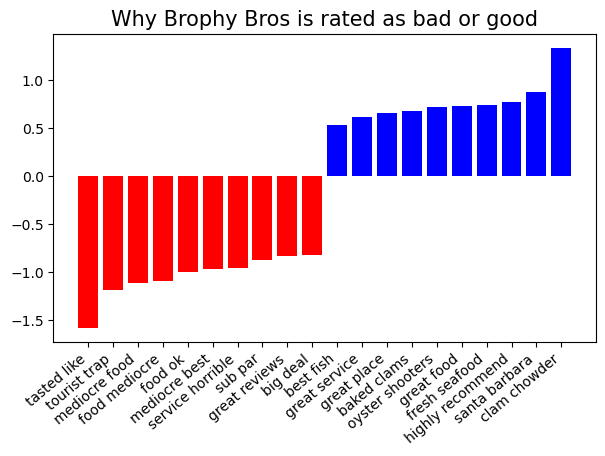

In [33]:
bigram(df_update,"Brophy Bros")